In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [2]:
df = pd.read_csv("heart.csv")
print("Dataset Loaded Successfully!\n")

Dataset Loaded Successfully!



In [4]:
X = df[['restecg', 'oldpeak']]  # keep only these two columns
y = df['target']                 # replace if your target column name is different

# Encode target if categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)
print("🔹 Train samples:", len(X_train))
print("🔹 Test samples:", len(X_test))


🔹 Train samples: 820
🔹 Test samples: 205


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
dt = DecisionTreeClassifier(random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

In [8]:
voting_hard = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb', xgb)],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)


voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:15:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:15:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=0)),
                             ('knn', KNeighborsClassifier()),
                             ('rf', RandomForestClassifier(random_state=0)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            ev...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [9]:
hard_pred = voting_hard.predict(X_test_scaled)
soft_pred = voting_soft.predict(X_test_scaled)


hard_acc = accuracy_score(y_test, hard_pred)
soft_acc = accuracy_score(y_test, soft_pred)


In [10]:
print("\n===== Voting Accuracy Comparison =====")
print(f"Hard Voting Accuracy : {hard_acc:.4f}")
print(f"Soft Voting Accuracy : {soft_acc:.4f}")

best_voting = 'soft' if soft_acc > hard_acc else 'hard'
print(f"\n Best Voting Type: {best_voting.upper()}")


===== Voting Accuracy Comparison =====
Hard Voting Accuracy : 0.7415
Soft Voting Accuracy : 0.7463

 Best Voting Type: SOFT


In [11]:
weights = [
    (1,1,1,1),
    (2,1,1,1),
    (1,2,2,1),
    (1,1,2,3),
    (3,2,1,1)
]

results = []
for w in weights:
    vc = VotingClassifier(
        estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb', xgb)],
        voting=best_voting,
        weights=w
    )

In [13]:
vc.fit(X_train_scaled, y_train)
y_pred = vc.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
results.append((w, acc))
print(f"Weights {w} -> Accuracy: {acc:.4f}")

best_weights, best_acc = max(results, key=lambda x: x[1])
print(f"\nBest Weights: {best_weights} with Accuracy: {best_acc:.4f}")


Weights (3, 2, 1, 1) -> Accuracy: 0.7463

Best Weights: (3, 2, 1, 1) with Accuracy: 0.7463


C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:17:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
train_sizes = np.linspace(0.2, 0.9, 8)
train_errors, test_errors = [], []

for size in train_sizes:
    X_train_sample,_,y_train_sample, _ = train_test_split(
        X_train_scaled, y_train, train_size=size, random_state=0, stratify=y_train
    )
    model = VotingClassifier(
        estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb', xgb)],
        voting=best_voting,
        weights=best_weights
    )
    model.fit(X_train_sample, y_train_sample)
    
    y_train_pred = model.predict(X_train_sample)
    y_test_pred = model.predict(X_test_scaled)
    
    train_errors.append(1 - accuracy_score(y_train_sample, y_train_pred))
    test_errors.append(1 - accuracy_score(y_test, y_test_pred))



C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:21:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:21:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:21:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Naveed Sheikh\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:21:47] WARNING: C:\actions-runner\_w

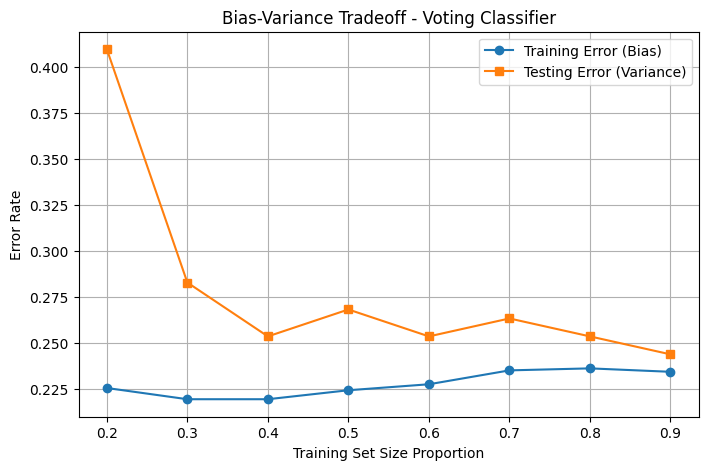


Bias-Variance Tradeoff plotted successfully!


In [18]:

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_errors, marker='o', label='Training Error (Bias)')
plt.plot(train_sizes, test_errors, marker='s', label='Testing Error (Variance)')
plt.title("Bias-Variance Tradeoff - Voting Classifier")
plt.xlabel("Training Set Size Proportion")
plt.ylabel("Error Rate")
plt.legend()
plt.grid(True)
plt.show()

print("\nBias-Variance Tradeoff plotted successfully!")